In [1]:
"""
Here I will build an RNN to implement the 2-Bit Flip task. This is generally modelled after (https://direct.mit.edu/neco/article/25/3/626/7854/Opening-the-Black-Box-Low-Dimensional-Dynamics-in)
where they implement a 3-Bit flip task and then break down the phase space to interpret how the network is implementing the computation. I would eventually like to do the same in models I build to
mimic the Medulla by reproducing motor outputs, however I will start here to practice in a simpler case.
"""

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import zutils
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)

torch.Size([50, 100, 2])
torch.Size([50, 100, 2])


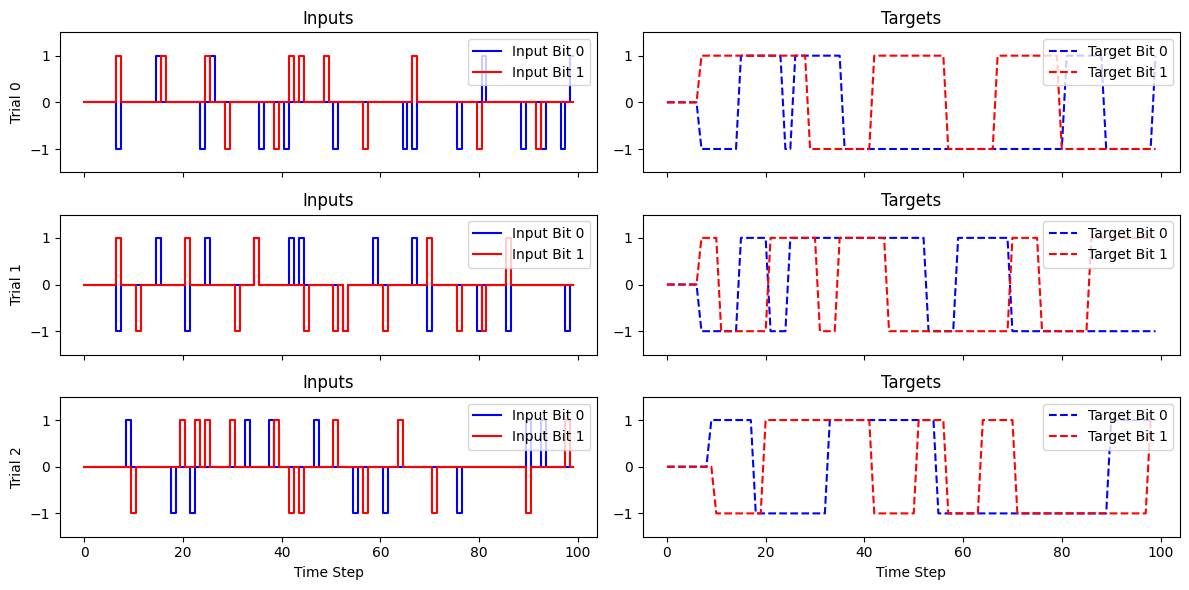

In [2]:
"""
Create and visualize the dataset
"""

X, Y = zutils.generate_2bit_flipflop_dataset(num_trials=50, trial_length=100, seed=42)
print(X.shape)  # (10, 40, 2)
print(Y.shape)  # (10, 40, 2)

zutils.plot_flipflop_trials(X, Y, num_trials_to_plot=3)


In [6]:
class FlipFlopRNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=100, output_size=2, num_layers=1):
        super(FlipFlopRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True,
                          bias=False,
                          nonlinearity='tanh')
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        out, _ = self.rnn(x)  # out shape: (batch, seq_len, hidden_size)
        out = self.output_layer(out)  # out shape: (batch, seq_len, output_size)
        return out


In [7]:
# Generate toy dataset
X_train, Y_train = zutils.generate_2bit_flipflop_dataset(num_trials=1000, trial_length=100, seed=42)
X_val, Y_val = zutils.generate_2bit_flipflop_dataset(num_trials=800, trial_length=100, seed=42)
X_test, Y_test = zutils.generate_2bit_flipflop_dataset(num_trials=500, trial_length=100, seed=42)

In [10]:
# Initialize model
model = FlipFlopRNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

val_loss_storage = []
val_accuracy_storage = []

# Training loop
for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = loss_fn(outputs, Y_train)
    loss.backward()
    optimizer.step()

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_accuracy = zutils.flipflop_accuracy(val_outputs, Y_val)
        val_loss = loss_fn(val_outputs, Y_val)

        val_accuracy_storage.append(val_accuracy)
        val_loss_storage.append(val_loss)
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {val_accuracy:.4f}")


Epoch 1, Train Loss: 0.9425, Val Loss: 0.8531, Val Acc: 0.0458
Epoch 2, Train Loss: 0.8514, Val Loss: 1.4258, Val Acc: 0.1980
Epoch 3, Train Loss: 1.4254, Val Loss: 0.7211, Val Acc: 0.0460
Epoch 4, Train Loss: 0.7200, Val Loss: 0.7171, Val Acc: 0.0664
Epoch 5, Train Loss: 0.7170, Val Loss: 0.7069, Val Acc: 0.0476
Epoch 6, Train Loss: 0.7061, Val Loss: 0.7215, Val Acc: 0.0536
Epoch 7, Train Loss: 0.7208, Val Loss: 0.7001, Val Acc: 0.0567
Epoch 8, Train Loss: 0.6996, Val Loss: 0.6345, Val Acc: 0.0641
Epoch 9, Train Loss: 0.6341, Val Loss: 0.5536, Val Acc: 0.0805
Epoch 10, Train Loss: 0.5536, Val Loss: 0.7055, Val Acc: 0.1175
Epoch 11, Train Loss: 0.7069, Val Loss: 0.5964, Val Acc: 0.0795
Epoch 12, Train Loss: 0.5961, Val Loss: 0.6720, Val Acc: 0.0746
Epoch 13, Train Loss: 0.6717, Val Loss: 0.6758, Val Acc: 0.0747
Epoch 14, Train Loss: 0.6755, Val Loss: 0.6366, Val Acc: 0.0798
Epoch 15, Train Loss: 0.6361, Val Loss: 0.5648, Val Acc: 0.1078
Epoch 16, Train Loss: 0.5640, Val Loss: 0.6458, V

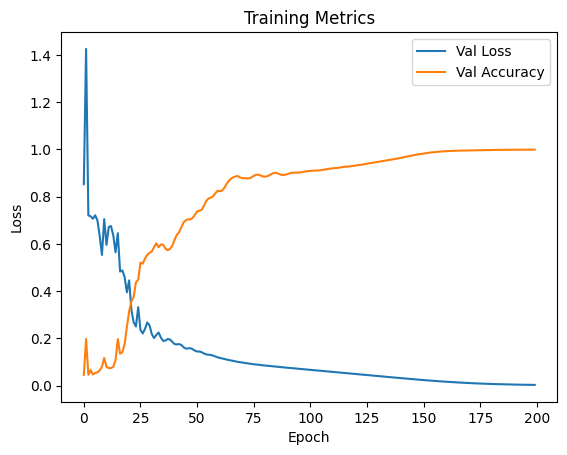

In [11]:
plt.plot(val_loss_storage, label="Val Loss")
plt.plot(val_accuracy_storage, label="Val Accuracy")
plt.title("Training Metrics")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [12]:
# Save model
torch.save(model.state_dict(), "BitFlipRNN_100h.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [13]:
# Load saved model
model = FlipFlopRNN()
model.load_state_dict(torch.load("BitFlipRNN_100h.pth", weights_only=True))

<All keys matched successfully>

In [14]:
model.eval()
x, y = X_test, Y_test
with torch.no_grad():
    pred = model(x)


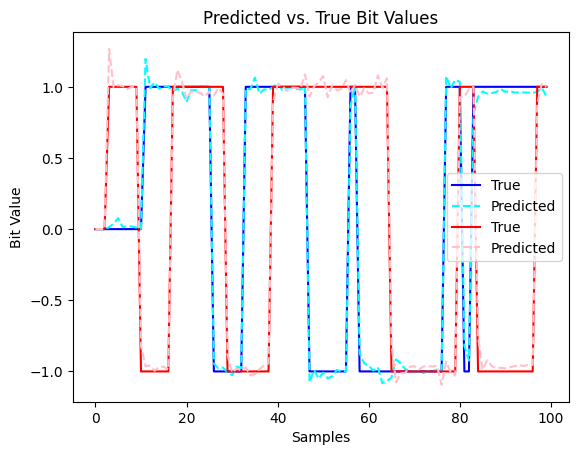

In [15]:
trial=10

plt.plot(y[trial][:,0], label="True", color="b")
plt.plot(pred[trial][:,0], linestyle="--", label="Predicted", color="cyan")

plt.plot(y[trial][:,1], label="True", color="r")
plt.plot(pred[trial][:,1], linestyle="--", label="Predicted", color="pink")

plt.xlabel("Samples")
plt.ylabel("Bit Value")
plt.legend()
plt.title("Predicted vs. True Bit Values")
plt.show()

In [16]:
# Choose a starting input (e.g., batch size = 1)
x0 = torch.zeros(1, 1, model.rnn.input_size)  # shape: (batch, seq_len, input_size)
h0 = torch.zeros(model.rnn.num_layers, 1, model.rnn.hidden_size)  # shape: (num_layers, batch, hidden_size)

# Construct all 4 possible input types
timesteps = 1000
one_input = torch.ones(1, 1, model.rnn.input_size)
negative_one_input = -torch.ones(1, 1, model.rnn.input_size)
one_negone_input = torch.tensor([[[1.0, -1.0]]])      # shape: (1, 1, 2)
negone_one_input = torch.tensor([[[-1.0, 1.0]]])      # shape: (1, 1, 2)
no_input = torch.zeros(1, timesteps-1, model.rnn.input_size)  # e.g., zero input

inputs, true_outputs = zutils.generate_2bit_flipflop_dataset(num_trials=1, trial_length=timesteps, seed=42, max_gap=30, p_input=0.2)

# Construct the inputs to move through some transitions
# inputs = torch.cat([one_input, no_input, negative_one_input, no_input, one_negone_input, no_input, negone_one_input, no_input], dim=1)

# Run model forward with those inputs, starting from zero inputs and zero hidden state
outputs, hidden_states = model.rnn(inputs, h0)  # outputs: (1, timesteps, hidden_size)

# Convert to numpy
hidden_acts = outputs.squeeze(0)  # shape: (timesteps, hidden_size)
hidden_np = hidden_acts.detach().cpu().numpy()  # shape: (timesteps, hidden_size)

# Compute covariance
# np.cov needs (vars, time)
C = np.cov(hidden_np.T)  # shape: (hidden_size, hidden_size)

# Eigenvalues
eigs = np.linalg.eigvalsh(C)

# Participation Ratio
pr = (eigs.sum() ** 2) / (eigs**2).sum()
print(f"Participation Ratio (effective dimensionality): {pr:.2f}")



Participation Ratio (effective dimensionality): 2.04


In [47]:
from sklearn.decomposition import PCA
import plotly.graph_objs as go

pca = PCA(n_components=3)
hidden_3d = pca.fit_transform(hidden_np)  # shape: (timesteps, 3)

# Create a color gradient over time
timesteps = np.arange(hidden_3d.shape[0])
colors = timesteps  # Can normalize if needed

# Create the 3D line plot
trace = go.Scatter3d(
    x=hidden_3d[:, 0],
    y=hidden_3d[:, 1],
    z=hidden_3d[:, 2],
    mode='lines+markers',
    marker=dict(
        size=4,
        color=colors,
        colorscale='Viridis',
        opacity=0.8
    ),
    line=dict(
        color='darkblue',
        width=2
    )
)

layout = go.Layout(
    title='Interactive 3D Hidden State Trajectory',
    scene=dict(
        xaxis_title='PC 1',
        yaxis_title='PC 2',
        zaxis_title='PC 3'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig = go.Figure(data=[trace], layout=layout)
fig.show()


In [ ]:
"""
I have a good sense now about what I might find. The model must contain 2^N memory states where N is the number of bits. By running the 
model forward on data and doing PCA (above), we can clearly see the 4 memory states for our 2-bit flip network. We now wish to identify interesting
areas in the dynamics. We can't simply check everywhere to explicitly create a flow field because the dimensionality is massive. Thus, we will
perform Q optimization as done in the referenced paper.

Steps
    1. Construct dataset containing all possible transitions and select M network states as ICs for Q-optimization.
    2. Q-optimize from each IC, saving the final network state for succesfull optimizations.
    3. Cluster the final network states to identify unique fixed points in the network space.
    4. Perform stability analysis to classify the fixed points (e.g. point attractor, saddle points, etc...)
        1. Compute the Jacobian around each point
        2. Do eigen-decomposition and analyze
"""

In [18]:
"""
1. Construct dataset containing all possible transitions and select M network states as ICs for Q-optimization.
"""
timesteps = 10000
inputs, true_outputs = zutils.generate_2bit_flipflop_dataset(num_trials=1, trial_length=timesteps, seed=42, max_gap=30, p_input=0.2)
outputs, hidden_states = model.rnn(inputs, h0)  # outputs: (1, timesteps, hidden_size)

# Convert to numpy
hidden_acts = outputs.squeeze(0)  # shape: (timesteps, hidden_size)
hidden_np = hidden_acts.detach().cpu().numpy()  # shape: (timesteps, hidden_size)

indices = np.arange(0, hidden_np.shape[0])

# Get sample indices randomly
n_samples=500
sample_indices = []
for i in range(n_samples):
    sample_indices.append(np.random.choice(indices).item())

# Extract network states at the sampled indices
ICs = hidden_np[sample_indices, :]

In [ ]:
"""
2. Q-optimize from each IC, saving the final network state for succesfull optimizations.
"""
from scipy.optimize import minimize

def Q(h, W_hh, W_ih, u):
    h = h.reshape(-1, 1)  # column vector
    u = u.reshape(-1, 1)  # column vector
    h_next = np.tanh(W_hh @ h + W_ih @ u)
    return 0.5 * np.sum((h_next - h)**2)

W_hh = model.rnn.weight_hh_l0.detach().numpy()
W_ih = model.rnn.weight_ih_l0.detach().numpy()

hidden_size = model.rnn.hidden_size
u = np.zeros(model.rnn.input_size)  # freeze input

# Perform Q optimization from each IC
results = []
for i in range(n_samples):
    if i % 10== 0 and i!= 0:
        print(i)
        print(res.message)
    res = minimize(Q, ICs[i,:], args=(W_hh, W_ih, u), method='BFGS')
    h_star = res.x
    results.append(res)

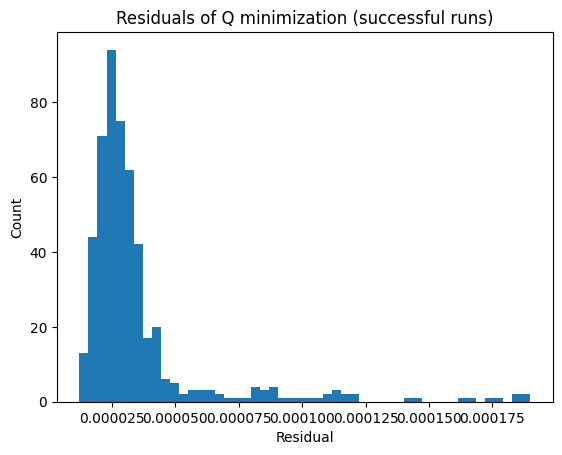

In [ ]:
# Find the ICs that converged
converged_hstars = [res.x for res in results if res.success]

# Calculate the Q val given the minimizer x
residuals = [
    np.linalg.norm(np.tanh(W_hh @ res.x.reshape(-1, 1) + W_ih @ u.reshape(-1, 1)) - res.x.reshape(-1, 1))
    for res in results if res.success
]

# Plot histogram of results
plt.hist(residuals, bins=50)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title("Residuals of Q minimization (successful runs)")
plt.show()

In [ ]:
# Store only fixed points with residual below threshold
threshold = 1e-4
converged_fixed_points = []
residuals = []

for res in results:
    if res.success:
        h_star = res.x.reshape(-1, 1)
        residual = np.linalg.norm(np.tanh(W_hh @ h_star + W_ih @ u.reshape(-1, 1)) - h_star)
        if residual < threshold:
            converged_fixed_points.append(res.x)  # or h_star.flatten()
            residuals.append(residual)

converged_fixed_points = np.array(converged_fixed_points)  # shape: (num_fixed, hidden_size)

In [62]:
# Project fixed points into the same PC space from earlier
fixed_points_3d = pca.transform(converged_fixed_points)  # shape: (num_fixed, 3)

# Create 3D scatter plot
scatter = go.Scatter3d(
    x=fixed_points_3d[:, 0],
    y=fixed_points_3d[:, 1],
    z=fixed_points_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color='red',
        opacity=0.9
    ),
    name='Fixed Points'
)

layout = go.Layout(
    title='Fixed Points in PC Space',
    scene=dict(
        xaxis_title='PC 1',
        yaxis_title='PC 2',
        zaxis_title='PC 3'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig = go.Figure(data=[scatter], layout=layout)
fig.show()


In [ ]:
# 3. Cluster the final network states to identify unique fixed points in the network space.
# Find each cluster mean in PC space, then put into network space to perform stability analysis
from sklearn.cluster import KMeans

# Kmeans cluster the 9 clusters in PC space
n_clusters = 9
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
labels = kmeans.fit_predict(fixed_points_3d)  # cluster assignments
centroids_3d = kmeans.cluster_centers_       # shape: (9, 3)

# Project points back into network space
centroids_network_space = pca.inverse_transform(centroids_3d)  # shape: (clusters, hidden_size)

In [68]:
"""
4. Perform stability analysis to classify the fixed points (e.g. point attractor, saddle points, etc...)
        1. Compute the Jacobian around each point
        2. Do eigen-decomposition and analyze
"""

stability_results = []
u_vec = u.reshape(-1, 1)  # ensure input is column vector

for i, h_star in enumerate(centroids_network_space):
    h_star = h_star.reshape(-1, 1)  # shape: (hidden_size, 1)
    
    # Pre-activation
    z = W_hh @ h_star + W_ih @ u_vec  # shape: (hidden_size, 1)
    
    # Derivative of tanh (Jacobian of activation)
    D = 1.0 - np.tanh(z) ** 2
    D_mat = np.diagflat(D)  # shape: (hidden_size, hidden_size)
    
    # Jacobian of the RNN dynamics at h_star
    J = D_mat @ W_hh
    
    # Compute eigenvalues
    eigs = np.linalg.eigvals(J)
    stability_results.append(eigs)


for i, eigs in enumerate(stability_results):
    spectral_radius = np.max(np.abs(eigs))
    stability = "Stable" if spectral_radius < 1 else "Unstable"
    print(f"Centroid {i}: {stability}, Spectral radius = {spectral_radius:.4f}")



Centroid 0: Stable, Spectral radius = 0.7164
Centroid 1: Stable, Spectral radius = 0.7166
Centroid 2: Stable, Spectral radius = 0.7213
Centroid 3: Stable, Spectral radius = 0.7220
Centroid 4: Unstable, Spectral radius = 1.1682
Centroid 5: Unstable, Spectral radius = 1.1682
Centroid 6: Unstable, Spectral radius = 1.1524
Centroid 7: Unstable, Spectral radius = 1.1524
Centroid 8: Unstable, Spectral radius = 1.1637


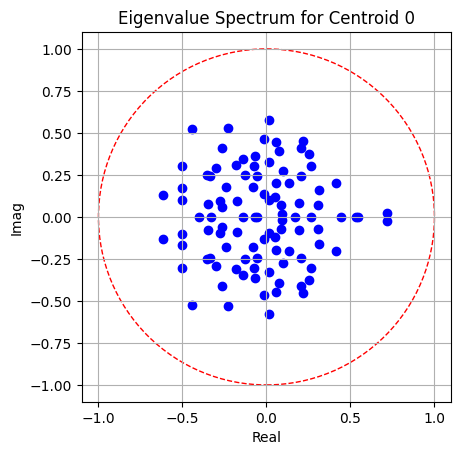

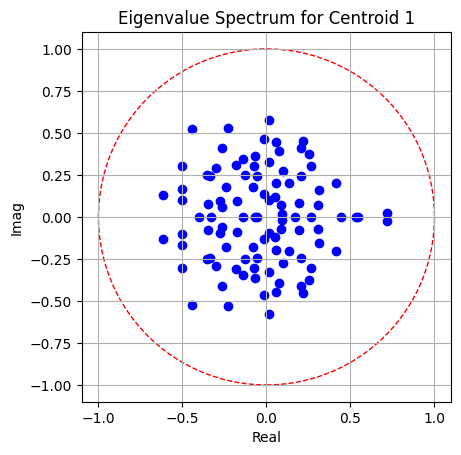

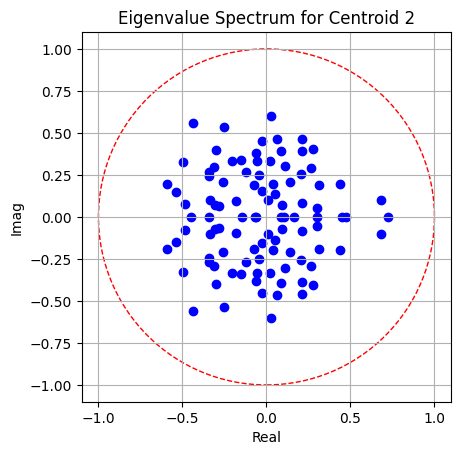

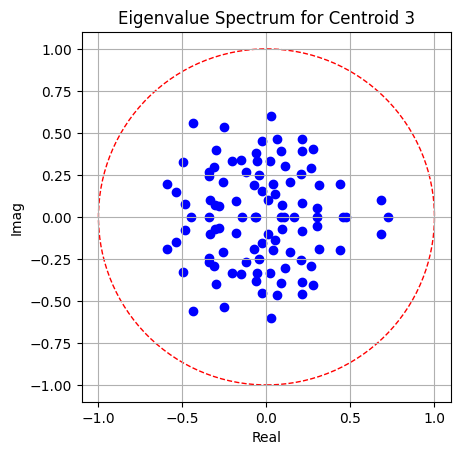

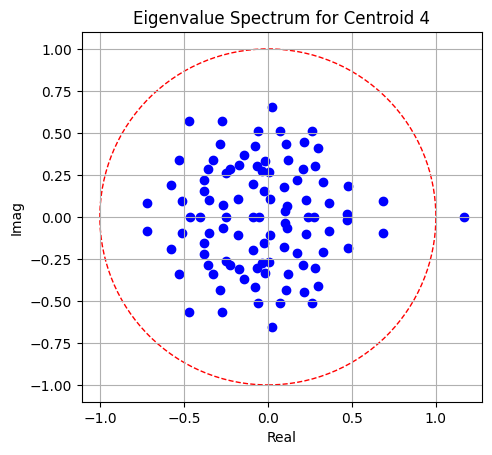

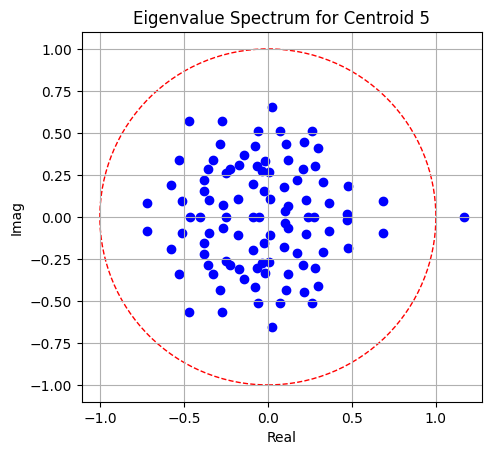

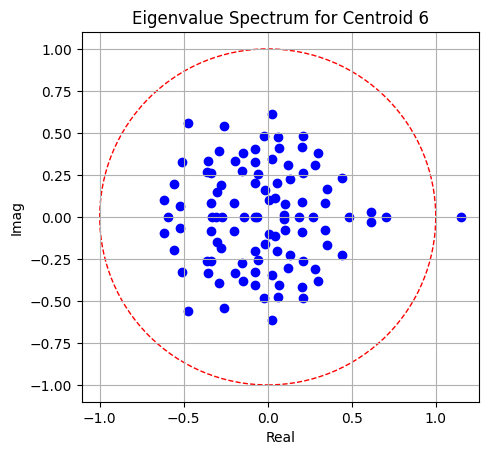

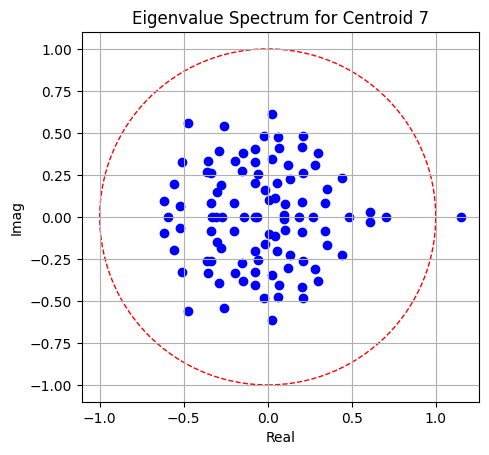

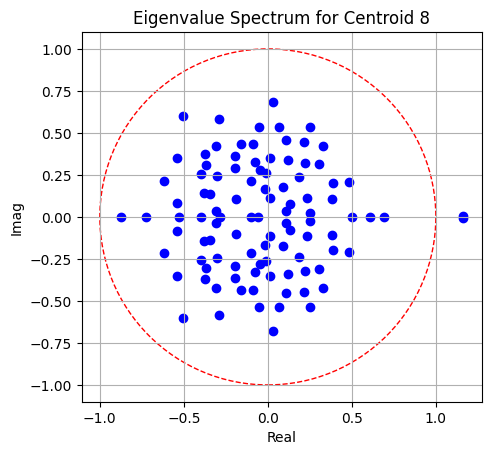

In [69]:
for i, eigs in enumerate(stability_results):
    plt.figure()
    plt.title(f'Eigenvalue Spectrum for Centroid {i}')
    plt.scatter(eigs.real, eigs.imag, c='blue')
    unit_circle = plt.Circle((0, 0), 1.0, color='r', fill=False, linestyle='--')
    plt.gca().add_patch(unit_circle)
    plt.gca().set_aspect('equal')
    plt.xlabel('Real')
    plt.ylabel('Imag')
    plt.grid(True)
    plt.show()
